In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import datetime
import matplotlib.ticker as mtick 
import datetime

## Plot EUSA curves

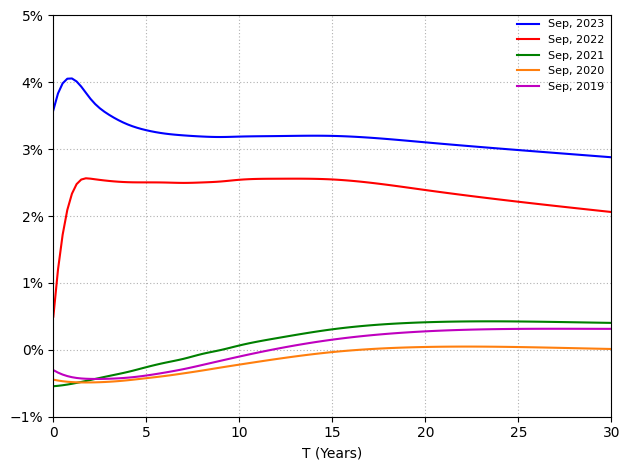

In [5]:
# curve data
os.chdir('INSERT_DATA_PATH_HERE')
EUSA = pd.read_excel('EUSA_data.xlsx')

# change dataframe layout
index = EUSA['Dates'].copy()
EUSA = pd.melt(EUSA.reset_index(),
               id_vars=['Dates'],
               value_vars=['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y'],
               var_name='Maturity', value_name='Spot rate').set_index(['Dates'])
EUSA.name = 'EUSA'

# convert strings to float
def maturity_convert(Maturity):
    if Maturity[-1] == 'M':
        MaturityInYear = float(Maturity[:-1]) / 12  # if 6M -> 6/12
    else:
        MaturityInYear = float(Maturity[:-1])       # if xY -> float(x)
    return MaturityInYear

EUSA['Maturity (years)'] = EUSA['Maturity'].apply(lambda x: maturity_convert(x))

# change % to decimal
EUSA['Spot rate (decimal)'] = EUSA['Spot rate'].apply(lambda x: x / 100)

# cubic spline interpolation
def cubspline_curve(date, T, df_curve):
    S = interp1d(df_curve['Maturity (years)'][str(date)], 
                 df_curve['Spot rate (decimal)'][str(date)], 
                 kind='cubic', 
                 fill_value='extrapolate')
    return S(T)

def create_cubic_curve_cc(t, T, tau, date, curve_data): # returns cubic spline interpolated curve in cont. comp. rates
    ts = pd.Series(np.arange(t, T+tau, tau))
    curve = ts.copy()

    for i in range(len(ts)):
        tt = ts.iloc[i]
        curve.iloc[i] = np.log(1 + cubspline_curve(date, tt, curve_data))

    samlet = pd.DataFrame(curve, columns =['Rate']).set_index(ts.values)
    samlet.index.name = 'T'

    return samlet

date_19 = datetime.date(2019,9,18)
cubic_swap_curve_19 = create_cubic_curve_cc(0, 30, 0.25, date_19, EUSA)

date_20 = datetime.date(2020,9,18)
cubic_swap_curve_20 = create_cubic_curve_cc(0, 30, 0.25, date_20, EUSA)

date_21 = datetime.date(2021,9,20)
cubic_swap_curve_21 = create_cubic_curve_cc(0, 30, 0.25, date_21, EUSA)

date_22 = datetime.date(2022,9,19)
cubic_swap_curve_22 = create_cubic_curve_cc(0, 30, 0.25, date_22, EUSA)

date_23 = datetime.date(2023,9,18)
cubic_swap_curve_23 = create_cubic_curve_cc(0, 30, 0.25, date_23, EUSA)


fig, ax = plt.subplots()

ax.set_xlim(0, 30)
ax.set_ylim(-0.01, 0.05)
ax.set_yticks(np.arange(-0.01, 0.06, 0.01))
ax.grid(ls = (0,(1,2)))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0))

plt.plot(cubic_swap_curve_23.index, cubic_swap_curve_23, color = 'b', label = 'Sep, 2023')
plt.plot(cubic_swap_curve_22.index, cubic_swap_curve_22, color = 'r', label = 'Sep, 2022')
plt.plot(cubic_swap_curve_21.index, cubic_swap_curve_21, color = 'g', label = 'Sep, 2021')
plt.plot(cubic_swap_curve_20.index, cubic_swap_curve_20, color = '#ff7f0e', label = 'Sep, 2020')
plt.plot(cubic_swap_curve_19.index, cubic_swap_curve_19, color = 'm', label = 'Sep, 2019')

plt.legend(frameon=False, bbox_to_anchor = (1.005, 1.015), fontsize=8)
plt.xlabel('T (Years)')
fig.tight_layout()